In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import pyranges as pr
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [6]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [7]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc


def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

# Load data

In [8]:
data_dir = os.path.expanduser('~/projects/metacells/data/CD34/Multiome/')

In [9]:
# RNA and ATAC data
samples = ['rep1', 'rep2']

rna_ad_dict, atac_ad_dict = dict(), dict()
for r in samples:
    comb_ad = sc.read_10x_h5(data_dir + r + '/filtered_feature_bc_matrix.h5', gex_only=False)
    
    # RNA
    rna_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types'] == 'Gene Expression']
    rna_ad_dict[r].var_names_make_unique()
    rna_ad_dict[r].obs['sample'] = r
    
    # ATAC
    atac_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types'] == 'Peaks']
    atac_ad_dict[r].var_names_make_unique()
    
    # Update cell names with sample names 
    rna_ad_dict[r].obs_names = atac_ad_dict[r].obs_names = 'cd34_multiome_' + r + '#'+ rna_ad_dict[r].obs_names

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
# Cells from each sample 
sample_cells = dict()
for sample in samples:
    sample_cells[sample] = rna_ad_dict[sample].obs_names

In [11]:
# Per barcode metrics 
bc_metrics_dict = dict()
for sample in samples:
    bc_metrics_dict[sample] = pd.read_csv(data_dir + r + '/per_barcode_metrics.csv', 
                index_col=0)
    bc_metrics_dict[sample].index = 'cd34_multiome_' + sample + '#' +bc_metrics_dict[sample].index 
    bc_metrics_dict[sample] = bc_metrics_dict[sample].loc[rna_ad_dict[sample].obs_names]
    # FRIP
    bc_metrics_dict[sample]['FRIP'] = bc_metrics_dict[sample]['atac_peak_region_fragments']/bc_metrics_dict[sample]['atac_fragments']

# Preprocess

## QC

In [12]:
# QC metrics include mitochondrial fractions from scanpy 
for r in samples:
    rna_ad = rna_ad_dict[r]
    rna_ad.var['mt'] = rna_ad.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(rna_ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False, )

In [13]:
# QC metrics include mitochondrial fractions from scanpy 
for r in samples:
    atac_ad = atac_ad_dict[r]
    sc.pp.calculate_qc_metrics(atac_ad, inplace=True, percent_top=None, log1p=False, )

### Filtering cells based on RNA

Text(0.5, 0.98, 'log10 molecule counts')

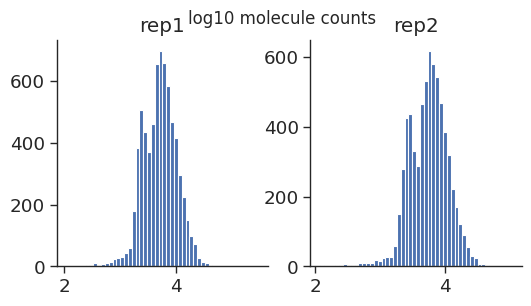

In [14]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

Text(0.5, 0.98, 'log10 molecule counts')

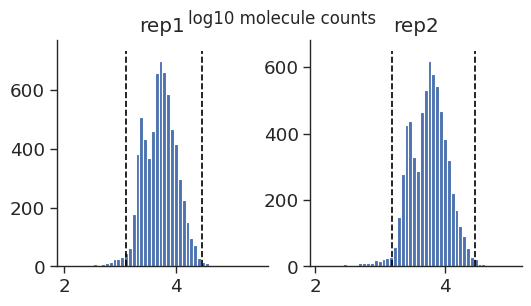

In [15]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    THRESHOLDS = np.log10(np.percentile((rna_ad.obs['total_counts']), [2.5, 99.5]))
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

In [16]:
for r in sample_cells.keys():
    print(len(sample_cells[r]))

6973
6797


In [17]:
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    cells = rna_ad.obs_names
    
    # Filter
    THRESHOLDS = np.percentile((rna_ad.obs['total_counts']), [2.5, 99.5])
    sample_cells[sample] = cells[(rna_ad.obs['total_counts'][cells] > THRESHOLDS[0]) & \
        (rna_ad.obs['total_counts'][cells] < THRESHOLDS[1])]

Text(0.5, 0.98, 'log10 molecule counts')

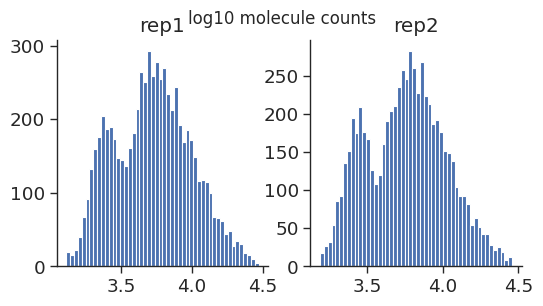

In [18]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

### Filtering based on ATAC

Text(0.5, 0.98, 'log10 fragment counts')

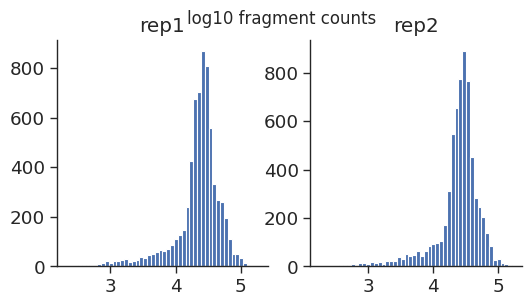

In [19]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    atac_ad = atac_ad_dict[sample]
    ax.hist(np.log10(atac_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 fragment counts')

Text(0.5, 0.98, 'Fraction of reads in peaks')

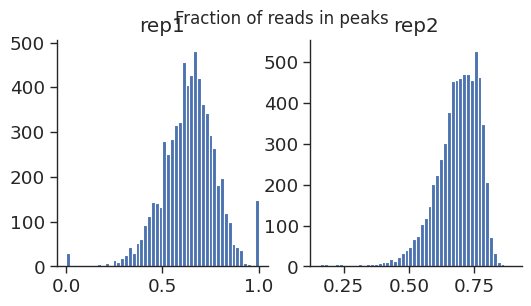

In [20]:
## CAUTION: CellRanger peak calling is unreliable and we only use it here to filter cells with low 
##          fraction of reads in peaks. This is ok since CellRanger peak caller dramatically over estimates 
##          the peak widths. We might incur some false negatives, but thats an acceptable error for filtering   
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    ax.hist(bc_metrics_dict[sample]['FRIP'][sample_cells[sample]], 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('Fraction of reads in peaks')

In [21]:
THRESHOLD = 0.4
for sample in samples:
    sample_cells[sample] = sample_cells[sample][bc_metrics_dict[sample]['FRIP'][sample_cells[sample]] > THRESHOLD]

Text(0.5, 0.98, 'log10 molecule counts')

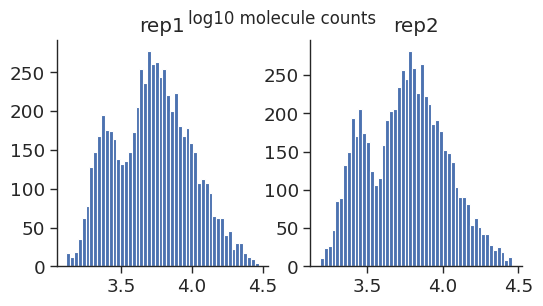

In [22]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

### Filter based on mitochondria

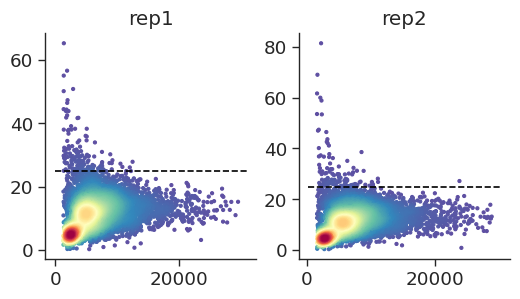

In [23]:
# Mitochondrial fractions compared to total molecules (colored by density)
MITO_THRESHOLD = 25
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    
    # Density 
    x,y,dens = palantir.plot.density_2d(rna_ad.obs['total_counts'][sample_cells[sample]], 
               rna_ad.obs['pct_counts_mt'][sample_cells[sample]])
    
    ax.scatter(x, y, c=dens, s=5)
    ax.hlines(MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')
    ax.set_title(sample)
sns.despine()



In [24]:
for sample in samples:
    cells = sample_cells[sample]
    sample_cells[sample] = cells[rna_ad_dict[sample].obs['pct_counts_mt'][cells] < MITO_THRESHOLD]

## Combine samples 

In [25]:
sample = samples[0]
ad = rna_ad_dict[sample][sample_cells[sample]]
for sample in samples[1:]:
    ad = ad.concatenate(rna_ad_dict[sample][sample_cells[sample]], 
                            index_unique=None, batch_key='batch')
ad

AnnData object with n_obs × n_vars = 12669 × 36601
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1'

In [26]:
raw_ad = ad.copy()

In [27]:
# Clean up var object
ad.var = pd.DataFrame(index=ad.var_names)

In [28]:
# Filter cells
sc.pp.filter_genes(ad, min_cells=50)

In [29]:
ad

AnnData object with n_obs × n_vars = 12669 × 17677
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'n_cells'

### Doublet scores (post filtering)

In [30]:
import scrublet as scr

In [31]:
doublet_scores = pd.Series(0.0, index=ad.obs_names)

for sample in samples:
    cells = ad.obs_names[ad.obs['sample'] == sample]
    scrub = scr.Scrublet(raw_ad[cells, :].X)
    scores, predicted_doublets = scrub.scrub_doublets()
    doublet_scores[cells] = scores

ad.obs['DoubletScores'] = doublet_scores.values

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 5.6%
Estimated detectable doublet fraction = 52.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.7%
Elapsed time: 7.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 3.9%
Estimated detectable doublet fraction = 48.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.1%
Elapsed time: 7.6 seconds


## Analysis

In [ ]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [ ]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=2500)
ad

In [ ]:
# PCA
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance
n_comps = 50
sc.pp.pca(ad, use_highly_variable=True, n_comps=n_comps)

In [ ]:
# UMAP and Leiden - requires the computation of nearest neighbors
# Ignore numba warnings in neighborhood computation
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_pca')
warnings.filterwarnings('default')
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

In [ ]:
# Diffusion maps 
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
warnings.filterwarnings('default')
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

In [ ]:
# Force directed layout
ad.obsm['X_FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

In [ ]:
# Phenograph 
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)
ad

In [ ]:
# Imputation
ad.obsm['MAGIC_imputed_data'] = impute_data(dm_res, ad)

# Visualize results

In [32]:
ad.obs['log_n_counts'] = np.log10(ad.obs['total_counts'])

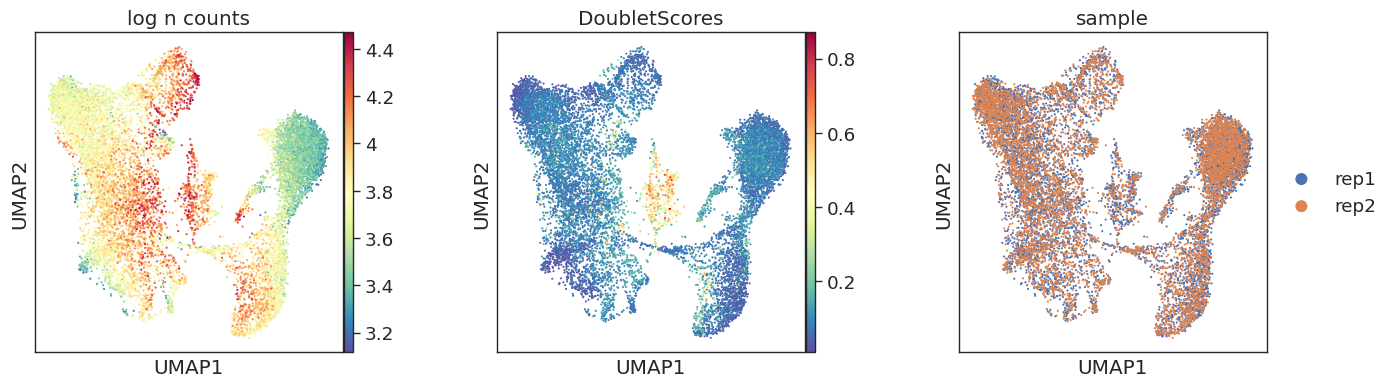

In [36]:
sc.pl.scatter(ad, basis='umap', color=['log_n_counts', 'DoubletScores', 'sample'])

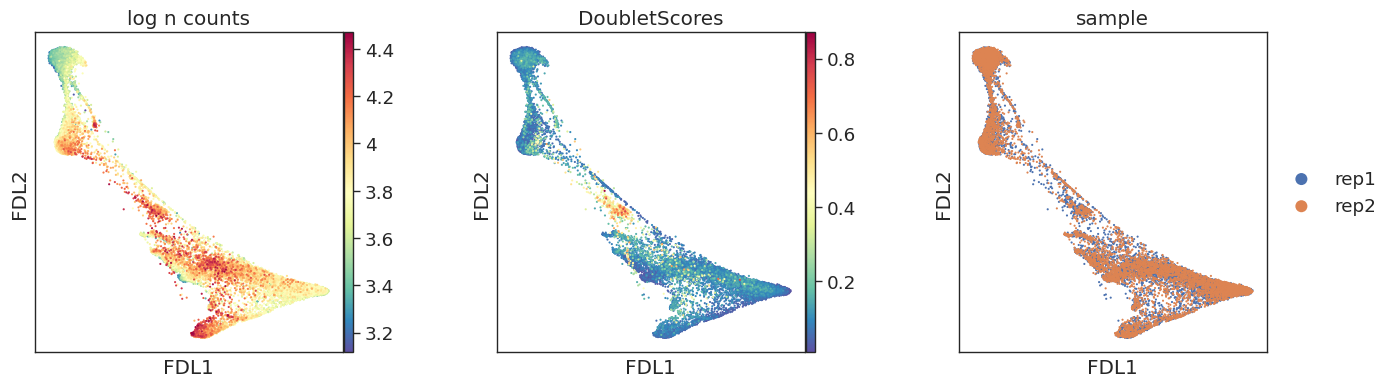

In [37]:
sc.pl.scatter(ad, basis='FDL', color=['log_n_counts', 'DoubletScores', 'sample'])

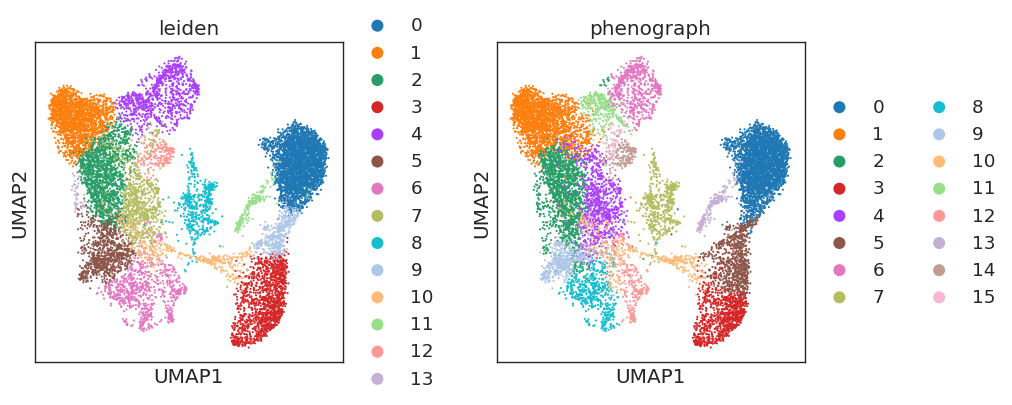

In [38]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])

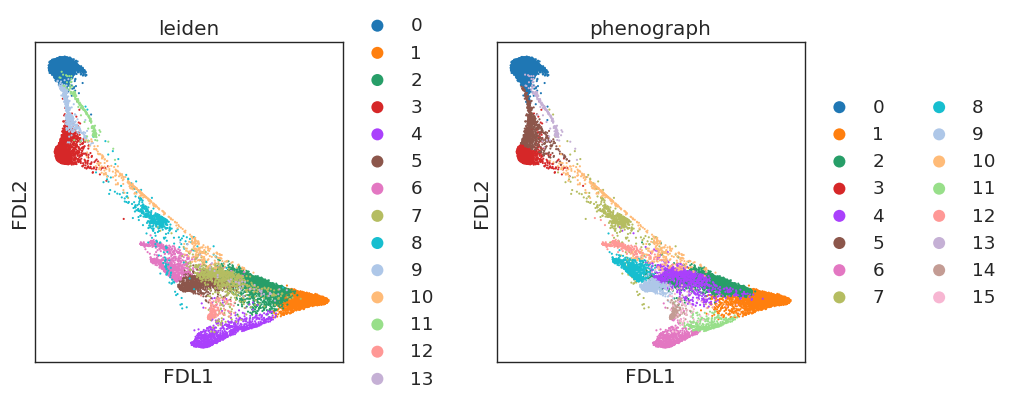

In [39]:
sc.pl.scatter(ad, basis='FDL', color=['leiden', 'phenograph'])

# Celltype annotation

In [42]:
genes = pd.Series([
    "CD34", "CD38", # HSPC
    "CD79B", "EBF1", "PAX5", # CLP / B cell lineage 
    "CD19", "CD20", # Mature B cell markers
    "GATA1",  # Erythroid lineage
    "IRF8", # DC lineage
    "MPO", # Monocyte lineage
    "ITGA2B", #CD41 - Megakaryocyte,   
    "HDC", "MS4A2" # BMCP - Basophil/Mast-cell precursor
])
genes = genes[genes.isin(ad.var_names)]

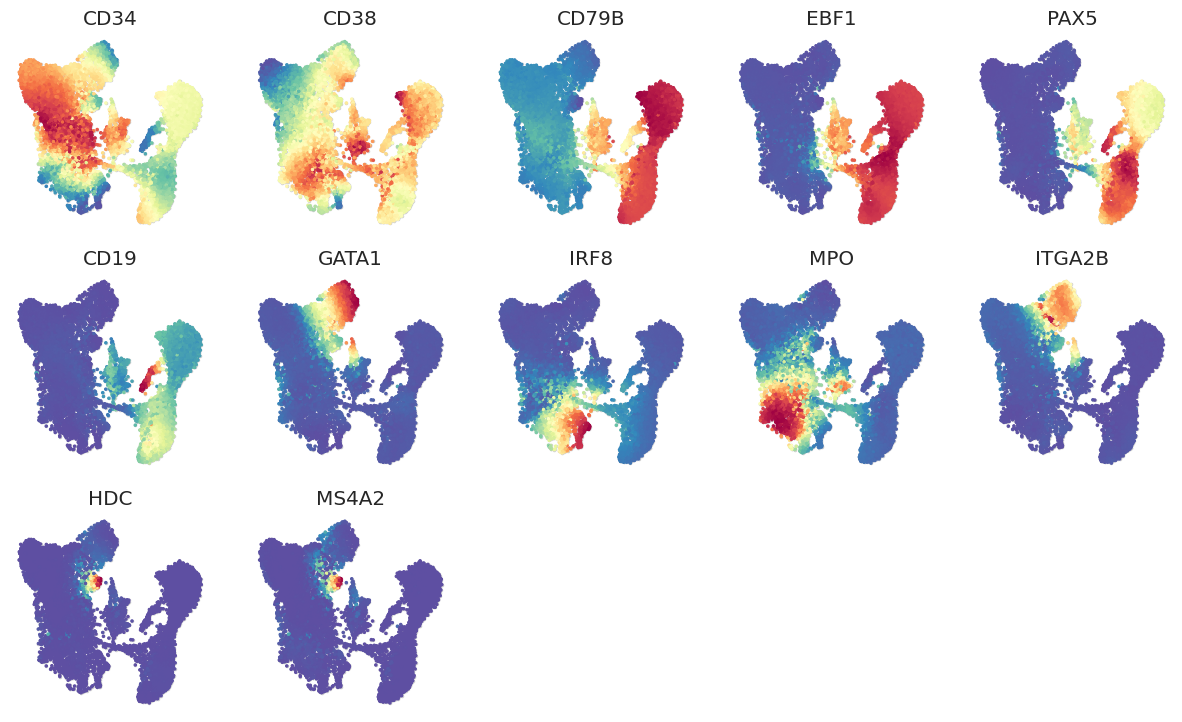

In [43]:
palantir.plot.plot_gene_expression(pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                                                index=ad.obs_names, columns=ad.var_names),
                                   pd.DataFrame(ad.obsm['X_umap'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   genes)

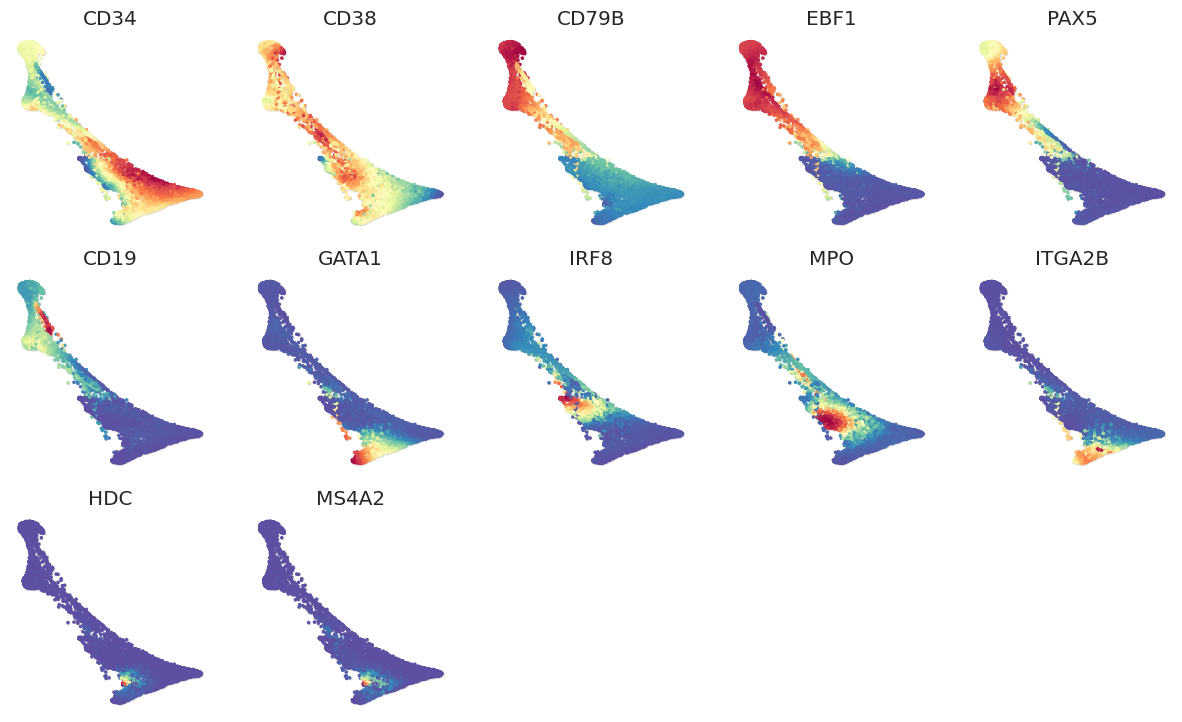

In [44]:
palantir.plot.plot_gene_expression(pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                                                index=ad.obs_names, columns=ad.var_names),
                                   pd.DataFrame(ad.obsm['X_FDL'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   genes)

In [ ]:
cell_types = pd.Series("", index=ad.obs['phenograph'].values.categories)
cell_types['0'] = 'B cells'
cell_types['1'] = 'HSPC'
cell_types['2'] = 'HSPC'
cell_types['3'] = 'B cells'
cell_types['4'] = 'HSPC'
cell_types['5'] = 'B cells'
cell_types['6'] = 'Ery'
cell_types['7'] = 'Doublets'
cell_types['8'] = 'Mono'
cell_types['9'] = 'Mono'
cell_types['10'] = 'CLP'
cell_types['11'] = 'Ery'
cell_types['12'] = 'DC'
cell_types['13'] = 'B cells'
cell_types['14'] = 'BMCP'
cell_types['15'] = 'Ery'

In [ ]:
ad.obs['celltype'] = cell_types[ad.obs['phenograph']].values

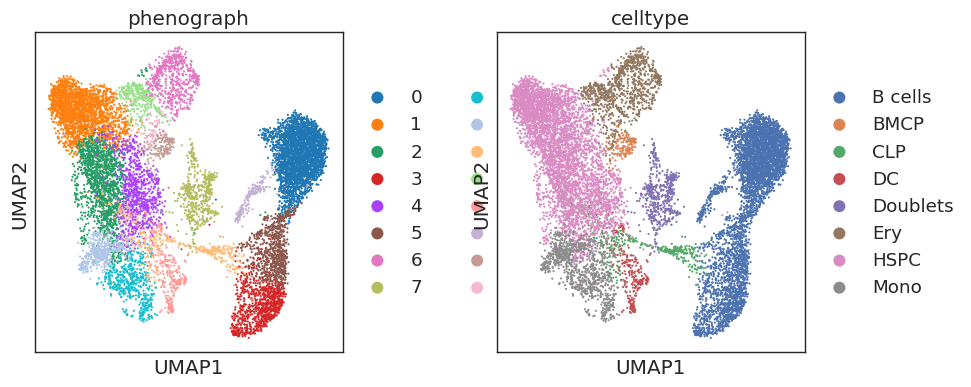

In [38]:
sc.pl.scatter(ad, basis='umap', color=['phenograph', 'celltype'])

# Save

In [ ]:
data_dir

In [ ]:
# Attach raw counts
ad.raw = sc.AnnData(raw_ad[ad.obs_names, :][:, ad.var_names].X)

In [ ]:
ad.write(data_dir + 'cd34_multiome_rna_all_cells.h5ad')

In [ ]:
# Export cell names for ATAC - only this subset of cells will be use for ATAC analysis
pd.DataFrame(ad.obs_names).to_csv(data_dir + 'cd34_multiome_all_cells.csv')

# Reprocess without B cells

## Analysis

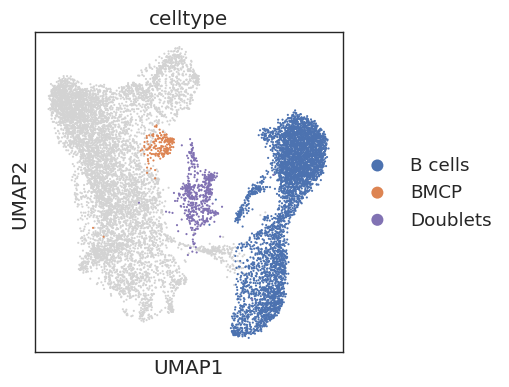

In [37]:
exclude = ['B cells', 'BMCP', 'Doublets']
sc.pl.scatter(ad, basis='umap', color=['celltype'], groups = exclude)

In [38]:
sub_ad = ad[~ad.obs['celltype'].isin(exclude), :]
sub_ad

View of AnnData object with n_obs × n_vars = 7071 × 17677
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap', 'celltype_colors'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [39]:
sub_ad

View of AnnData object with n_obs × n_vars = 7071 × 17677
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap', 'celltype_colors'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [40]:
sc.pp.filter_genes(sub_ad, min_cells=100)
sub_ad

Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 7071 × 14273
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap', 'celltype_colors'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [41]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(sub_ad, flavor='cell_ranger', n_top_genes=1500)
sub_ad

AnnData object with n_obs × n_vars = 7071 × 14273
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap', 'celltype_colors'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [42]:
# PCA
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance
n_comps = 50
sc.pp.pca(sub_ad, use_highly_variable=True, n_comps=n_comps)

In [43]:
# UMAP and Leiden - requires the computation of nearest neighbors
# Ignore numba warnings in neighborhood computation
warnings.filterwarnings('ignore')
sc.pp.neighbors(sub_ad, use_rep='X_pca')
warnings.filterwarnings('default')
sc.tl.umap(sub_ad)
sc.tl.leiden(sub_ad)
sub_ad

AnnData object with n_obs × n_vars = 7071 × 14273
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap', 'celltype_colors'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [50]:
# Phenograph 
sub_ad.obs['phenograph'], _, _ = phenograph.cluster(sub_ad.obsm['X_pca'])
sub_ad.obs['phenograph'] = sub_ad.obs['phenograph'].astype(str)
sub_ad

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.7563462257385254 seconds
Jaccard graph constructed in 1.125537395477295 seconds


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/phenograph/core.py:186: ResourceWarning: unclosed file <_io.TextIOWrapper name='76453eda4e4811edbb4707b8c4a9a903.tree' mode='w' encoding='UTF-8'>
  f.writelines([e for t in zip(ij, s) for e in t])


Wrote graph to binary file in 0.8105683326721191 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794123
After 2 runs, maximum modularity is Q = 0.795171
Louvain completed 22 runs in 3.05915904045105 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 7.466895341873169 seconds


AnnData object with n_obs × n_vars = 7071 × 14273
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap', 'celltype_colors'
    obsm: 'DM_EigenVectors', 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

## Visualize results

In [51]:
del sub_ad.uns['sample_colors']

... storing 'phenograph' as categorical


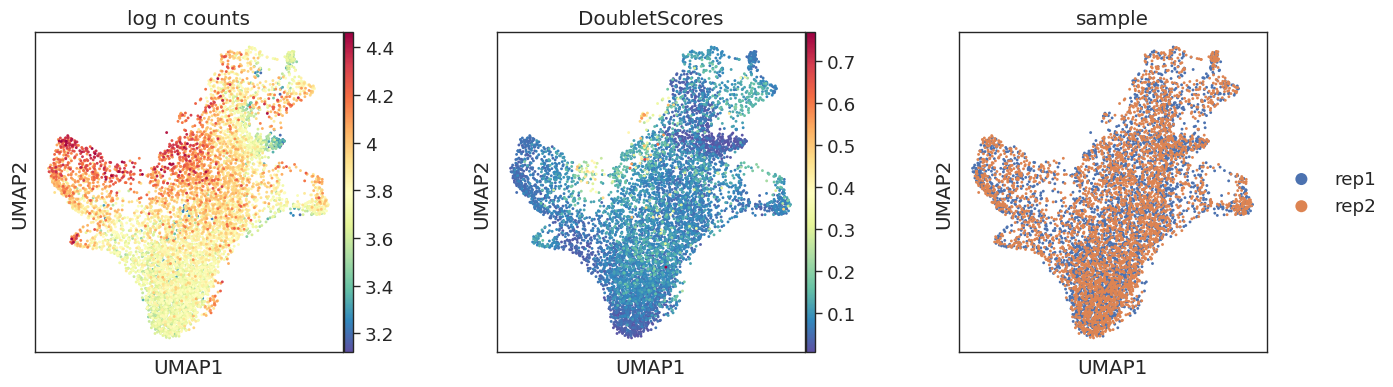

In [52]:
sc.pl.scatter(sub_ad, basis='umap', color=['log_n_counts', 'DoubletScores', 'sample'])

In [53]:
del sub_ad.uns['leiden_colors']
del sub_ad.uns['phenograph_colors']

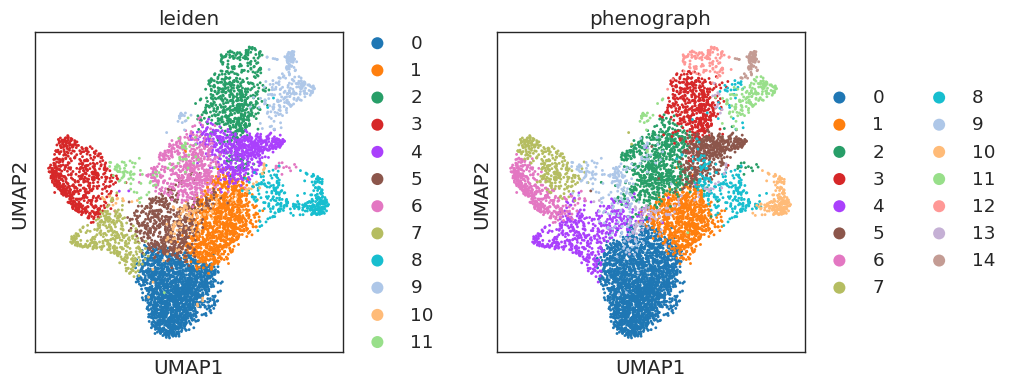

In [54]:
sc.pl.scatter(sub_ad, basis='umap', color=['leiden', 'phenograph'])

## Further clean up of doublets

<AxesSubplot:xlabel='cluster', ylabel='DoubletScores'>

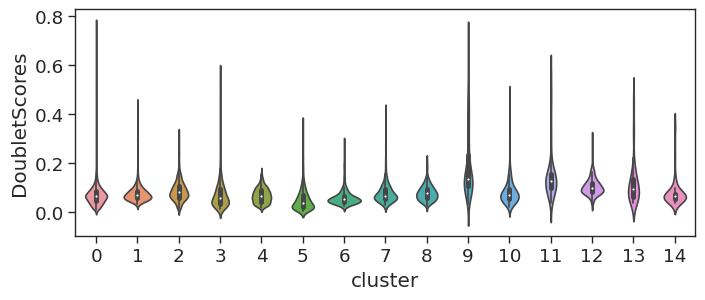

In [55]:
df = pd.DataFrame(sub_ad.obs['DoubletScores'])
df['cluster'] = sub_ad.obs['phenograph']

plt.figure(figsize=[8, 3])
ax = plt.gca()
sns.violinplot(x='cluster', y='DoubletScores', data=df, ax=ax)

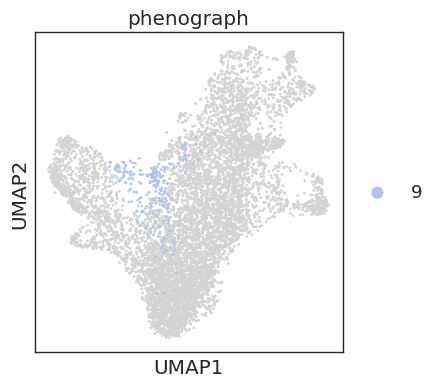

In [59]:
sc.pl.scatter(sub_ad, basis='umap', color=['phenograph'], groups=['9'])

## Reanalyse

In [62]:
sub_ad2 = sub_ad[sub_ad.obs['phenograph'] != '9', :]

In [ ]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(sub_ad2, flavor='cell_ranger', n_top_genes=1500)

# PCA
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance
n_comps = 50
sc.pp.pca(sub_ad2, use_highly_variable=True, n_comps=n_comps)

# UMAP and Leiden - requires the computation of nearest neighbors
# Ignore numba warnings in neighborhood computation
warnings.filterwarnings('ignore')
sc.pp.neighbors(sub_ad2, use_rep='X_pca')
warnings.filterwarnings('default')
sc.tl.umap(sub_ad2)
sc.tl.leiden(sub_ad2)

# Diffusion maps 
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(sub_ad2.obsm['X_pca'], index=sub_ad2.obs_names))
warnings.filterwarnings('default')
sub_ad2.obsp['DM_Kernel'] = dm_res['kernel']
sub_ad2.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
sub_ad2.uns['DMEigenValues'] = dm_res['EigenValues'].values

# Force directed layout
sub_ad2.obsm['X_FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

# Phenograph 
sub_ad2.obs['phenograph'], _, _ = phenograph.cluster(sub_ad2.obsm['X_pca'])
sub_ad2.obs['phenograph'] = sub_ad2.obs['phenograph'].astype(str)

# Imputation
sub_ad2.obsm['MAGIC_imputed_data'] = impute_data(dm_res, sub_ad2)

## Visualize results

In [40]:
del sub_ad2.uns['sample_colors']

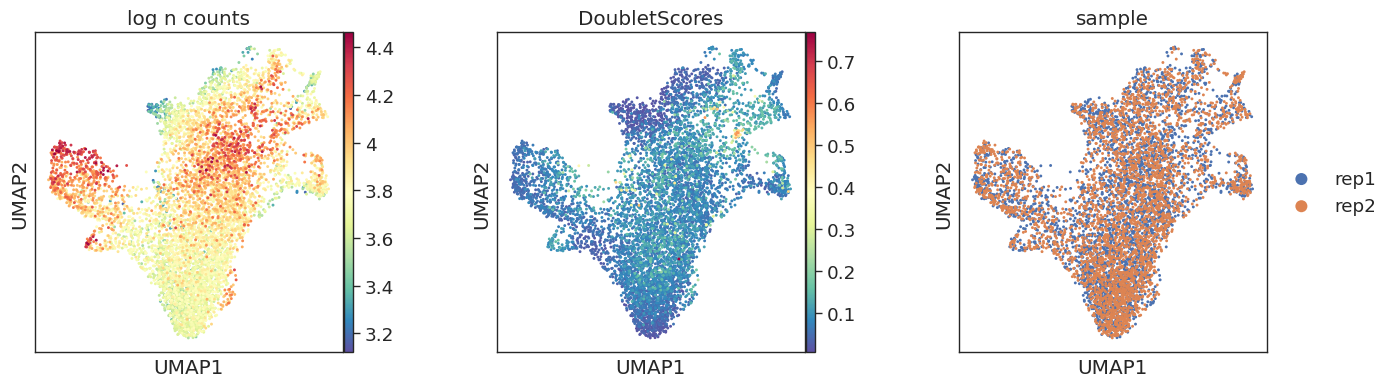

In [41]:
sc.pl.scatter(sub_ad2, basis='umap', color=['log_n_counts', 'DoubletScores', 'sample'])

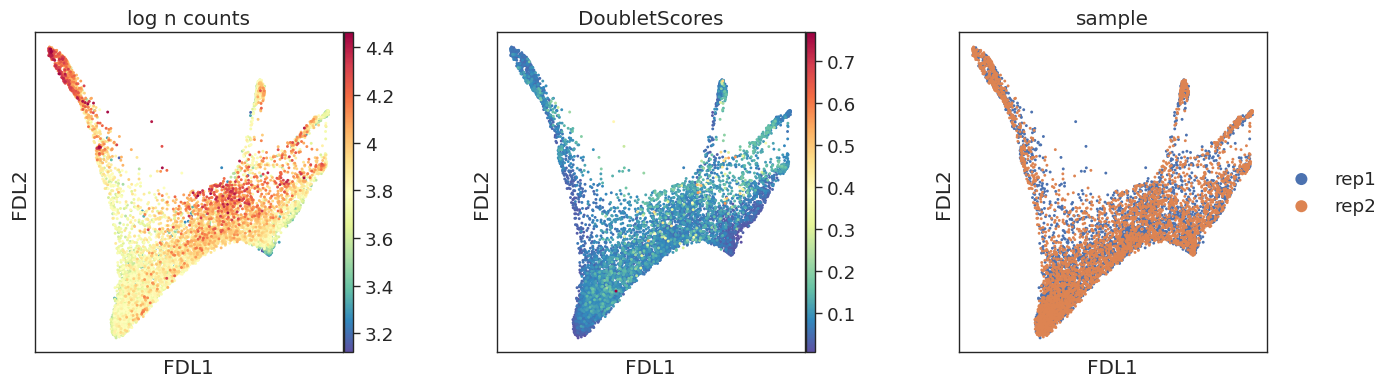

In [42]:
sc.pl.scatter(sub_ad2, basis='FDL', color=['log_n_counts', 'DoubletScores', 'sample'])

In [44]:
del sub_ad2.uns['leiden_colors']
del sub_ad2.uns['phenograph_colors']

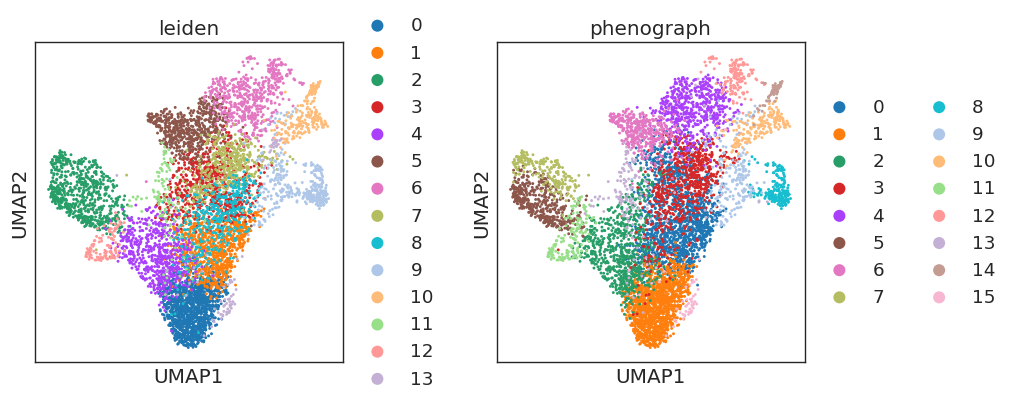

In [45]:
sc.pl.scatter(sub_ad2, basis='umap', color=['leiden', 'phenograph'])

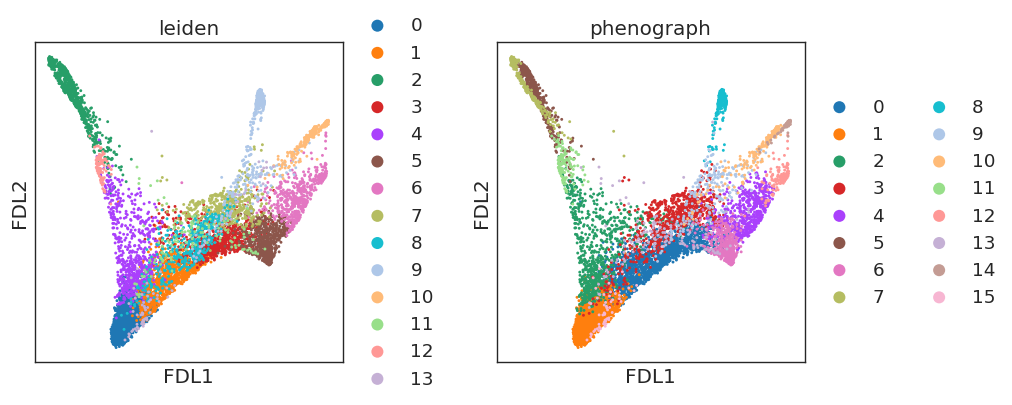

In [46]:
sc.pl.scatter(sub_ad2, basis='FDL', color=['leiden', 'phenograph'])

## Refine cell types

In [65]:
genes = pd.Series([
    "CD34", "CD38", # HSPC
    "CD79B", "EBF1", "PAX5", # CLP / B cell lineage 
    "GATA1",  # Erythroid lineage
    "IRF8", # DC lineage
    "MPO", # Monocyte lineage
    "ITGA2B", #CD41 - Megakaryocyte,     
    "SLC24A3", # Mega - Ery
])
genes = genes[genes.isin(ad.var_names)]

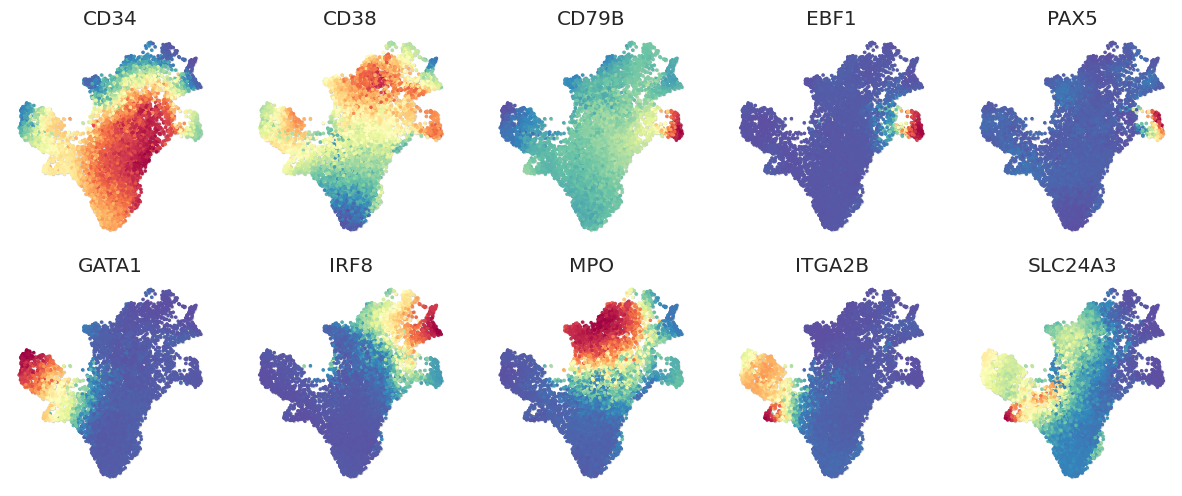

In [69]:
palantir.plot.plot_gene_expression(pd.DataFrame(sub_ad2.layers['MAGIC_imputed_data'], 
                                                index=sub_ad2.obs_names, columns=sub_ad2.var_names),
                                   pd.DataFrame(sub_ad2.obsm['X_umap'], 
                                               index=sub_ad2.obs_names, columns=['x', 'y']), 
                                   genes)

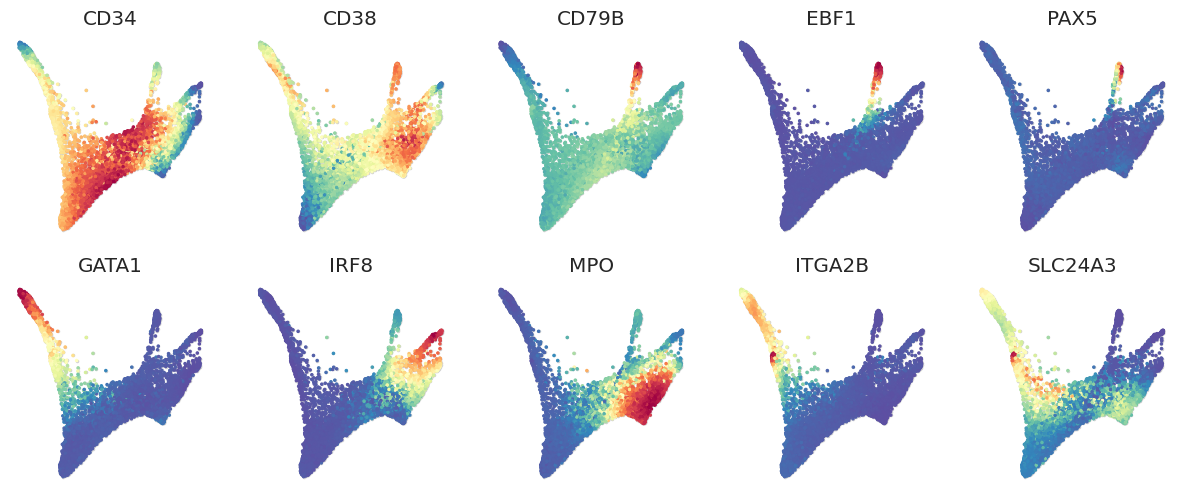

In [70]:
palantir.plot.plot_gene_expression(pd.DataFrame(sub_ad2.layers['MAGIC_imputed_data'], 
                                                index=sub_ad2.obs_names, columns=sub_ad2.var_names),
                                   pd.DataFrame(sub_ad2.obsm['X_FDL'], 
                                               index=sub_ad2.obs_names, columns=['x', 'y']), 
                                   genes)

In [ ]:
cell_types = pd.Series("", index=sub_ad.obs['phenograph'].values.categories)
cell_types['0'] = 'HSC'
cell_types['1'] = 'HMP'
cell_types['2'] = 'HMP'
cell_types['3'] = 'Mono'
cell_types['4'] = 'Mono'
cell_types['5'] = 'MEP'
cell_types['6'] = 'Ery'
cell_types['7'] = 'Ery'
cell_types['8'] = 'CLP'
cell_types['9'] = 'CLP'
cell_types['10'] = 'pDC'
cell_types['11'] = 'cDC'
cell_types['12'] = 'HMP'
cell_types['13'] = 'pDC'

In [ ]:
sub_ad2.obs['celltype'] = cell_types[sub_ad2.obs['phenograph']].values

In [47]:
del sub_ad2.uns['celltype_colors']

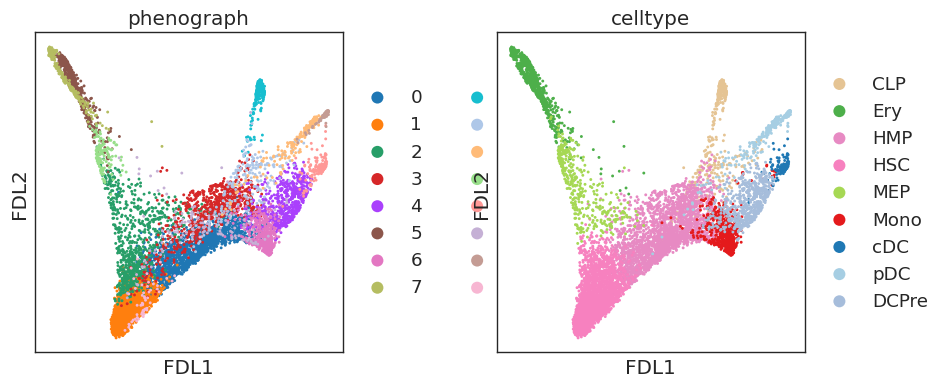

In [72]:
sc.pl.scatter(sub_ad2, basis='FDL', color=['phenograph', 'celltype'])

## Save

In [ ]:
# Attach raw counts
sub_ad2.raw = sc.AnnData(raw_ad[sub_ad2.obs_names, :][:, sub_ad2.var_names].X)

In [ ]:
sub_ad2.write(data_dir + 'cd34_multiome_rna_no_bcells.h5ad')

In [ ]:
# Export cell names for ATAC - only this subset of cells will be use for ATAC analysis
pd.DataFrame(sub_ad2.obs_names).to_csv(data_dir + 'cd34_multiome_no_bcells.csv')